# 3.1 Library Setup & Data Loading

In [5]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 21.7 MB/s eta 0:00:00


In [14]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Hyperparameter Tuning
import optuna

In [ ]:
# Preprocessing
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [10]:
from sklearn.model_selection import train_test_split

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import os

In [ ]:
# Algorithm
from sklearn.linear_model import LogisticRegression

In [ ]:
# Model Saving
import joblib

In [8]:
# [IMPORTANT!] Change the Path When Going Back to VS Code! Add parameter engine='fastparquet'!
train_df = pd.read_parquet('/content/drive/MyDrive/Repositories/telco-customer-churn-prediction/data/processed/train_df.parquet')

# 3.2 Data Preprocessing

In [9]:
# Filter only the columns you selected
selected_features = [
    'data_usage_change_2wk', 'spend_change_2wk',
    'video_data_change_2wk', 'messaging_data_change_2wk',
    'pct_data_on_video_w3_4', 'pct_data_on_messaging_w3_4'
    ]
target_col = 'churn'

# X and y setup
X = train_df[selected_features]
y = train_df[target_col]

In [11]:
# Create training and validation sets (for Modeling without Hyperparameter-Tuning)
# Use an 80/20 split: 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("--- Data Splitting Complete ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train churn rate: {y_train.value_counts(normalize=True).loc[1]:.4f}")
print(f"y_val churn rate: {y_val.value_counts(normalize=True).loc[1]:.4f}")

--- Data Splitting Complete ---
X_train shape: (41603, 6)
X_val shape: (10401, 6)
y_train churn rate: 0.2312
y_val churn rate: 0.2311


# 3.3 Modeling & Evaluation

## 3.3.1 Without Hyperparameter Tuning

In [12]:
# --- Preprocessing Pipeline ---
# PowerTransformer(method='yeo-johnson') makes data Gaussian-like and handles skew
numeric_transformer_nht = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handle missing values
    ('transformer', PowerTransformer(method='yeo-johnson')), # Make Gaussian-like
    ('scaler', StandardScaler()) # Standard Scale
])

preprocessor_nht = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_nht, selected_features)
    ])

# --- Full Pipeline (Impute -> Transform -> SMOTE -> Model) ---
clf_nht = ImbPipeline(steps=[
    ('preprocessor', preprocessor_nht),
    ('smote', SMOTE(random_state=42)), # Balances data ONLY on training folds
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [13]:
# --- Train the Logistic Regression Pipeline ---
print("--- Training the Logistic Regression Model ---")

# Fit the Logistic Regression pipeline on the training data
clf_nht.fit(X_train, y_train)

print("Logistic regression model trained successfully!")

--- Training the Logistic Regression Model ---
Logistic regression model trained successfully!


In [17]:
# Classification Report Function
def evaluate_classification(model, X, y, model_name="Logistic Regression", save_dir=None, file_prefix="lr_val"):
    print(f"--- Evaluating {model_name} ---")

    # Make Predictions
    y_pred = model.predict(X)

    # Classification Report
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y, y_pred, target_names=['Not Churned (0)', 'Churned (1)']))

    # 3. Confusion Matrix
    print(f"\nConfusion Matrix ({model_name}):")
    fig, ax = plt.subplots(figsize=(6, 5)) # Create a new figure
    ConfusionMatrixDisplay.from_estimator(
        model,
        X,
        y,
        display_labels=['Not Churned', 'Churned'],
        cmap='Blues',
        ax=ax
    )
    plt.title(f'{model_name} Confusion Matrix')

    # Save Logic
    if save_dir:
        os.makedirs(save_dir, exist_ok=True) # Ensure folder exists
        filename = f"confusion_matrix_{file_prefix}.png"
        file_path = os.path.join(save_dir, filename)
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved successfully to: {file_path}")

    plt.show()

    # ROC-AUC Curve
    print(f"\nROC-AUC Curve ({model_name}):")
    fig, ax = plt.subplots(figsize=(6, 5)) # Create a new figure
    RocCurveDisplay.from_estimator(
        model,
        X,
        y,
        ax=ax
    )
    plt.title(f'{model_name} ROC-AUC Curve')

    # Save Logic
    if save_dir:
        filename = f"ROC_{file_prefix}.png"
        file_path = os.path.join(save_dir, filename)
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        print(f"ROC saved successfully to: {file_path}")

    plt.show()

--- Evaluating Logistic Regression ---

Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

Not Churned (0)       0.91      0.73      0.81     31985
    Churned (1)       0.46      0.74      0.57      9618

       accuracy                           0.74     41603
      macro avg       0.68      0.74      0.69     41603
   weighted avg       0.80      0.74      0.75     41603


Confusion Matrix (Logistic Regression):


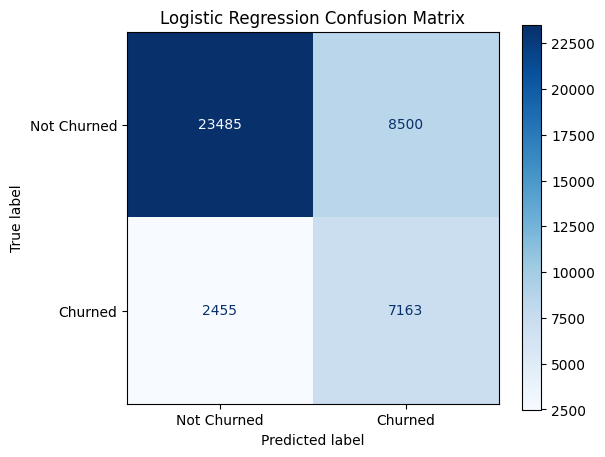


ROC-AUC Curve (Logistic Regression):


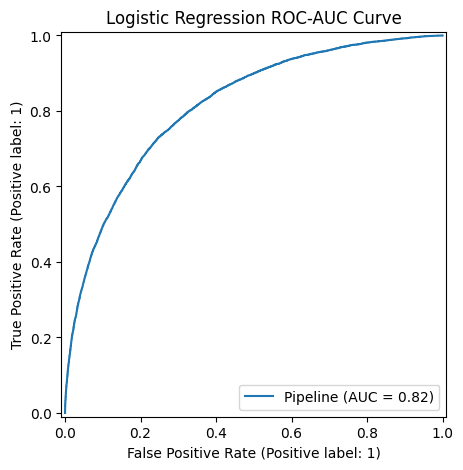

In [18]:
evaluate_classification(clf_nht, X_train, y_train, model_name="Logistic Regression")

--- Evaluating Logistic Regression ---

Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

Not Churned (0)       0.90      0.73      0.81      7997
    Churned (1)       0.45      0.74      0.56      2404

       accuracy                           0.73     10401
      macro avg       0.68      0.73      0.68     10401
   weighted avg       0.80      0.73      0.75     10401


Confusion Matrix (Logistic Regression):


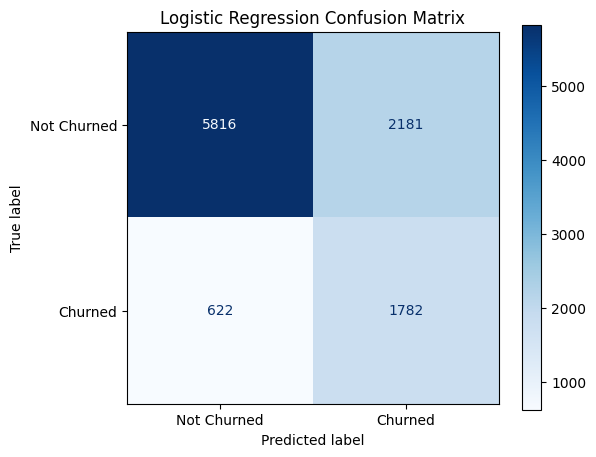


ROC-AUC Curve (Logistic Regression):


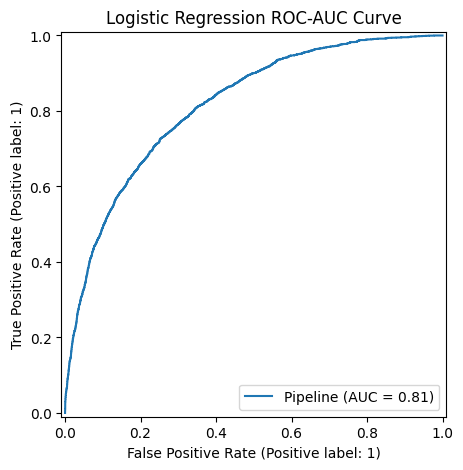

In [19]:
evaluate_classification(clf_nht, X_val, y_val, model_name="Logistic Regression")

In [ ]:
# Define the Objective Function
def objective(trial):
    # --- Hyperparameters to tune ---
    C = trial.suggest_float('C', 0.0001, 10, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    # Note: 'elasticnet' works with 'saga'. If pure l2 is chosen, l1_ratio is ignored by solver but required by API
    penalty = trial.suggest_categorical('penalty', ['elasticnet', 'l2'])

    # --- Preprocessing Pipeline ---
    # PowerTransformer(method='yeo-johnson') makes data Gaussian-like and handles skew
    numeric_transformer = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Handle missing values
        ('transformer', PowerTransformer(method='yeo-johnson')), # Make Gaussian-like
        ('scaler', StandardScaler()) # Standard Scale
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, selected_features)
        ])

    # --- Model Definition ---
    # solver='saga' is required for elasticnet and handles L1/L2
    # n_jobs=-1 uses all CPU cores (sklearn LogReg is mostly CPU bound)
    model = LogisticRegression(
        solver='saga',
        max_iter=1000,
        C=C,
        penalty=penalty,
        l1_ratio=l1_ratio if penalty == 'elasticnet' else None,
        random_state=42,
        n_jobs=-1
    )

    # --- Full Pipeline (Impute -> Transform -> SMOTE -> Model) ---
    clf = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)), # Balances data ONLY on training folds
        ('classifier', model)
    ])

    # --- Cross Validation Strategy ---
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Scoring: You prioritized Recall
    scores = cross_val_score(clf, X, y, cv=cv, scoring='recall', n_jobs=-1)

    return scores.mean()

# 4. Run Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Adjust trials as needed

print("Best Recall:", study.best_value)
print("Best Params:", study.best_params)

# 5. Train Final Model with Best Params and Save
best_params = study.best_params
final_model = LogisticRegression(
    solver='saga',
    max_iter=1000,
    C=best_params['C'],
    penalty=best_params['penalty'],
    l1_ratio=best_params['l1_ratio'] if best_params['penalty'] == 'elasticnet' else None,
    random_state=42
)

# Re-create pipeline with best model
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
            ('num', ImbPipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('transformer', PowerTransformer(method='yeo-johnson')),
                ('scaler', StandardScaler())
            ]), selected_features)
        ])),
    ('smote', SMOTE(random_state=42)),
    ('classifier', final_model)
])

final_pipeline.fit(X, y)

# Save as .pkl
joblib.dump(final_pipeline, 'final_churn_model.pkl')